# 0.0. Import 

In [1]:
import math
import pandas as pd
import inflection 
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from IPython.core.display import HTML

## 0.1 Helper Func


In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data


In [6]:
df_bank_raw = pd.read_csv ('churn.csv', low_memory=False)

# 1.0 Descriçao de Dados

In [7]:
df1 = df_bank_raw.copy()

In [9]:
df1.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 1.2. Data Dimensions

In [10]:
print('Number of Rows: {}' .format(df1.shape[0]))
print('Number of Columns: {}' .format(df1.shape[1]))

Number of Rows: 10000
Number of Columns: 14


## 1.3. Data Type

In [12]:
df1.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

## 1.4 Check NA

In [13]:
df1.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## 1.5 Descriptive Statiscal

In [16]:
#numerical
num_attribute = df1.select_dtypes ( include=['int64','float64'])

#categorical
cat_attribute = df1.select_dtypes (exclude=['int64', 'float64'])

## 1.7.1 Numerical Statiscal

In [22]:
num_attribute.apply( lambda x: x.unique().shape[0])

RowNumber          10000
CustomerId         10000
CreditScore          460
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [19]:
#Central Tendency - mean, median 
ct1 = pd.DataFrame(num_attribute.apply(np.mean)).T
ct2 = pd.DataFrame(num_attribute.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_attribute.apply(np.std)).T
d2 = pd.DataFrame(num_attribute.apply(min)).T
d3 = pd.DataFrame(num_attribute.apply(max)).T
d4 = pd.DataFrame(num_attribute.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attribute.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attribute.apply(lambda x: x.kurtosis())).T
                  
#concat
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes' ,'min' ,'max' ,'range' ,'mean' ,'median' ,'std' ,'skew' ,'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,RowNumber,1.00,10000.00,9999.00,5.000500e+03,5.000500e+03,2886.751332,0.000000,-1.200000
1,CustomerId,15565701.00,15815690.00,249989.00,1.569094e+07,1.569074e+07,71932.589224,0.001149,-1.196113
2,CreditScore,350.00,850.00,500.00,6.505288e+02,6.520000e+02,96.648466,-0.071607,-0.425726
3,Age,18.00,92.00,74.00,3.892180e+01,3.700000e+01,10.487282,1.011320,1.395347
4,Tenure,0.00,10.00,10.00,5.012800e+00,5.000000e+00,2.892030,0.010991,-1.165225
5,Balance,0.00,250898.09,250898.09,7.648589e+04,9.719854e+04,62394.285254,-0.141109,-1.489412
6,NumOfProducts,1.00,4.00,3.00,1.530200e+00,1.000000e+00,0.581625,0.745568,0.582981
7,HasCrCard,0.00,1.00,1.00,7.055000e-01,1.000000e+00,0.455818,-0.901812,-1.186973
8,IsActiveMember,0.00,1.00,1.00,5.151000e-01,1.000000e+00,0.499772,-0.060437,-1.996747
9,EstimatedSalary,11.58,199992.48,199980.90,1.000902e+05,1.001939e+05,57507.617221,0.002085,-1.181518


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

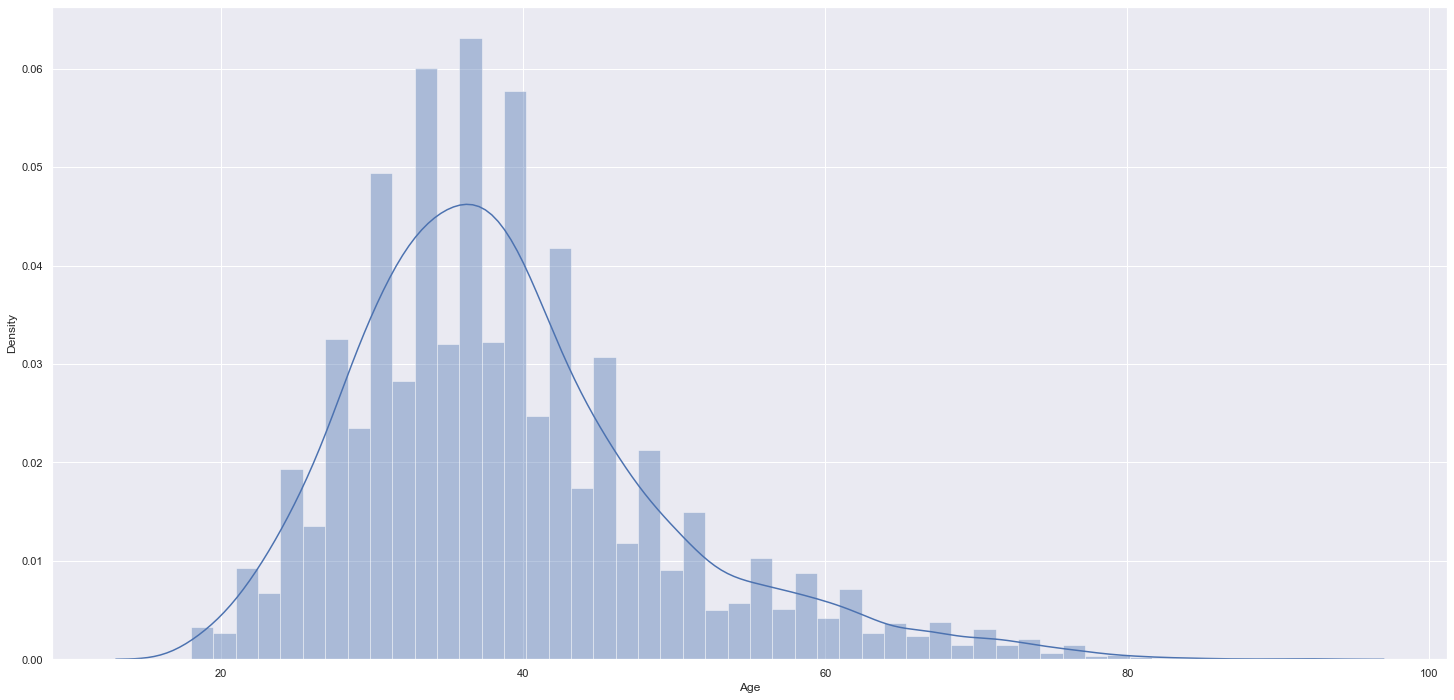

In [20]:
sns.distplot(df1['Age'])

## 1.7.2 Categorical Statiscal

In [21]:
cat_attribute.apply( lambda x: x.unique().shape[0])

Surname      2932
Geography       3
Gender          2
dtype: int64

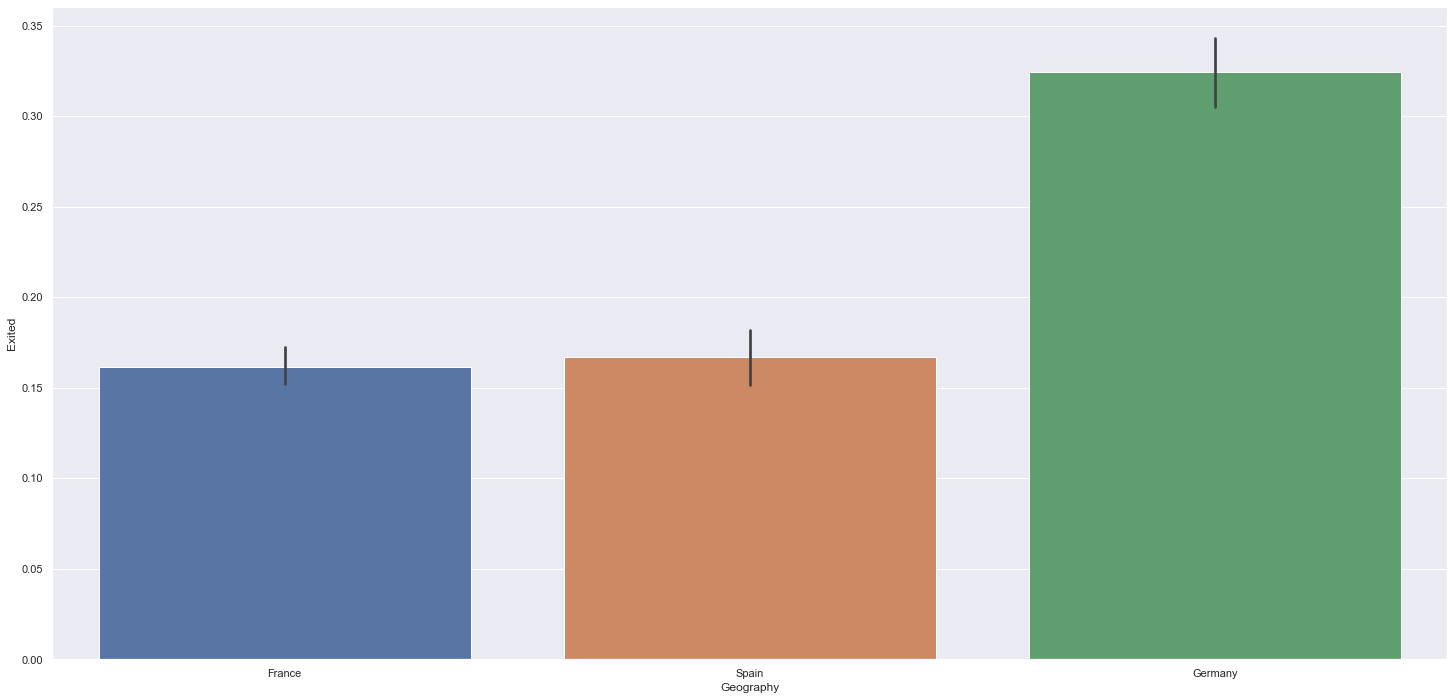

In [46]:
aux1 = df1[['Geography','Exited']].groupby('Geography').sum().reset_index

sns.barplot (x='Geography', y='Exited', data=df1);

#aux1= df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

#plt.subplot(1,3,1)
#sns.boxplot(x='Geography', y='Exited' ,  data=df1)

#plt.subplot(1,3,2)
#sns.boxplot(x='store_type', y='sales' ,  data=aux1)

#plt.subplot(1,3,3)
#sns.boxplot(x='assortment', y='sales' ,  data=aux1)